In [5]:
import sys
import json
import gpflow
import dataset
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, NullFormatter

%matplotlib inline

In [13]:
%load_ext autoreload
%autoreload 2
sys.path.append("../autoSDC/")
from asdc import emulation
from asdc import visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
import asdc

In [9]:
def deposition_flow_rate(ins):
    i = json.loads(ins)
    try:
        return i[0]["rates"]["CuSO4"]
    except KeyError:
        return None


def deposition_potential(df):
    p = []
    for idx, row in df.iterrows():

        if row["intent"] == "deposition":
            instructions = json.loads(row["instructions"])
            for instruction in json.loads(row["instructions"]):
                if instruction.get("op") == "potentiostatic":
                    p.append(instruction.get("potential"))
        elif row["intent"] == "corrosion":
            p.append(None)
    return p


datadir = Path("../data/electrodeposition/Cu-deposition-2019-11-21")
dbfile = datadir / "data/sdc.db"
dbfile
db = dataset.connect(f"sqlite:///{dbfile}")
df = pd.DataFrame(db["experiment"].all())

df["flow_rate"] = df["instructions"].apply(deposition_flow_rate)
df["potential"] = deposition_potential(df)
df[["flow_rate", "potential"]] = df[["flow_rate", "potential"]].fillna(method="ffill")


In [10]:
query_levels = np.array([0.030, 0.050, 0.10, 0.30])
levels = [np.linspace(0.030, 0.30, 100), np.linspace(-0.17, -0.05, 100)]
ndim = [len(l) for l in levels][::-1]
extent = [np.min(levels[0]), np.max(levels[0]), np.min(levels[1]), np.max(levels[1])]
xx, yy = np.meshgrid(levels[0], levels[1])
candidates = np.c_[xx.flatten(), yy.flatten()]


In [224]:
def load_datasets(experiment_id=np.inf):
    r = pd.DataFrame(db["result"].all())
    dep = df.loc[
        df["intent"] == "deposition",
        ("id", "experiment_id", "flow_rate", "potential", "coverage", "reflectance"),
    ]
    cor = df.loc[
        df["intent"] == "corrosion", ("id", "experiment_id", "flow_rate", "potential")
    ]
    cor = cor.merge(r, on="id")

    # merge deposition quality into corrosion table...
    # drop any corrosion experiments where the coverage was below spec
    cor = cor.merge(
        df.loc[:, ("experiment_id", "coverage")].groupby("experiment_id").min(),
        on="experiment_id",
    )

    next_exp = dep[dep["experiment_id"] == experiment_id + 1]

    cor = cor[cor["experiment_id"] <= experiment_id]
    dep = dep[dep["experiment_id"] <= experiment_id]

    X_dep = dep.loc[:, ("flow_rate", "potential")].values
    Y_dep = (dep["coverage"].values > 0.9).astype(float)

    X_cor = cor.loc[:, ("flow_rate", "potential")].values
    Y_cor = cor["integral_current"].values[:, None]

    # fit reflectance model only where coverage is good
    ref_selection = Y_dep == 1.0
    X_ref = X_dep[ref_selection]
    Y_ref = dep["reflectance"].values[ref_selection][:, None]

    try:
        X_next = next_exp.loc[:, ("flow_rate", "potential")].values[0]
    except IndexError:
        X_next = None

    return X_dep, Y_dep, X_cor, Y_cor, X_ref, Y_ref, X_next


def display_model(m,  candidates, X_obs, Y_obs=None, cvg=None, X_next=None, X_dep=None):
    loc, var = m.predict_y(candidates)
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

    loc = np.array(loc)
    var = np.array(var)

    ax = axes[0]
    I = ax.imshow(
        loc[:, 0].reshape(xx.shape), origin="lower", extent=extent, cmap="Blues"
    )
    visualization.colorbar(I)

    if Y_obs is None:
        ax.scatter(X_obs[:, 0], X_obs[:, 1], color="k", s=80, edgecolor="w")
    else: 
        styles = {0: dict(color="none", edgecolor="k"), 1: dict(color="k", edgecolor="w")}
        for val, style in styles.items():
            s = Y_obs == val
            ax.scatter(
                X_obs[s, 0],
                X_obs[s, 1],
                color=style["color"],
                edgecolor=style["edgecolor"],
                s=80,
            )

    ax = axes[1]
    I = ax.imshow(
        var[:, 0].reshape(xx.shape), origin="lower", extent=extent, cmap="Blues"
    )
    visualization.colorbar(I)
    ax.scatter(X_obs[:, 0], X_obs[:, 1], color="k")

    if cvg is not None:
        cvg_loc, _ = cvg.predict_y(candidates)
        cvg_loc = np.array(cvg_loc)

        for ax in axes:
            ax.contour(
                cvg_loc[:, 0].reshape(xx.shape),
                origin="lower",
                extent=extent,
                levels=[0.5],
                colors="k",
                linestyles="--",
            )

    if X_next is not None:
        for ax in axes:
            ax.scatter(X_next[0], X_next[1], color="r")

    if X_dep is not None:
        for ax in axes:
            ax.scatter(
                X_dep[:, 0], X_dep[:, 1], color="none", edgecolors="k", alpha=0.5
            )

    for ax in axes:
        ax.semilogx()
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.set_xticks([0.03, 0.1, 0.3])
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_xlabel("flow rate (mL/min)")

    axes[0].set_ylabel("Potential (V vs Ag/AgCl)")

    plt.tight_layout()
    for lvl in query_levels:
        axes[0].axvline(lvl, linestyle="--", color="k", alpha=0.2)


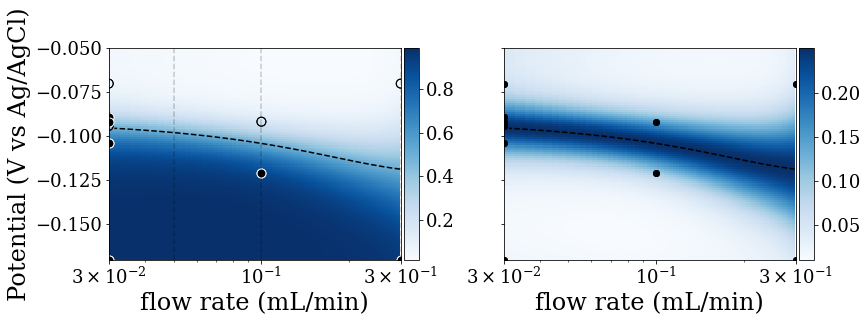

In [182]:
X_dep, Y_dep, X_cor, Y_cor, X_ref, Y_ref, X_next = load_datasets(experiment_id=10)
XX_dep = np.c_[np.log(X_dep[:,0]), X_dep[:,1]]
ccandidates = np.c_[np.log(candidates[:,0]), candidates[:,1]]

dx = 1 * np.ptp(candidates, axis=0)
ls = 2 * dx / 3
m_cov = emulation.model_quality(    
    X_dep, Y_dep[:, None], dx=dx, ls=ls, likelihood="bernoulli", optimize=True, optimize_ls=False
)
display_model(m_cov,  candidates, X_dep, Y_dep, cvg=m_cov, X_next=X_next)


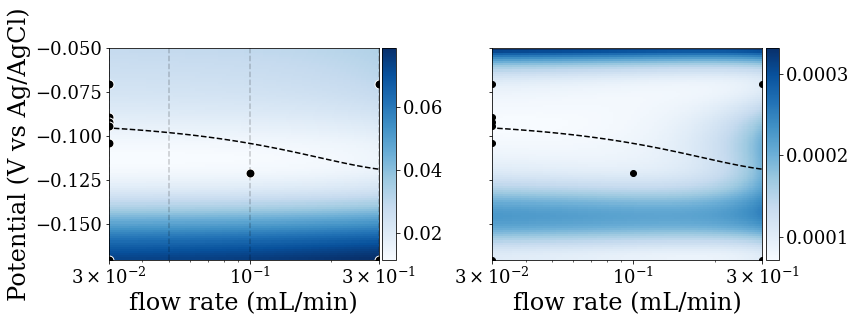

In [225]:
dx = 0.5 * np.ptp(candidates, axis=0)
ls = 2 * dx / 3
m_corr = emulation.model_property(X_cor, Y_cor, ls=ls, optimize=True)
# display_model(m_corr, X_cor, cvg=m_cov, X_dep=X_dep)
display_model(m_corr,  candidates, X_cor, cvg=m_cov, X_next=X_next)

In [214]:
dx

array([0.27, 0.12])

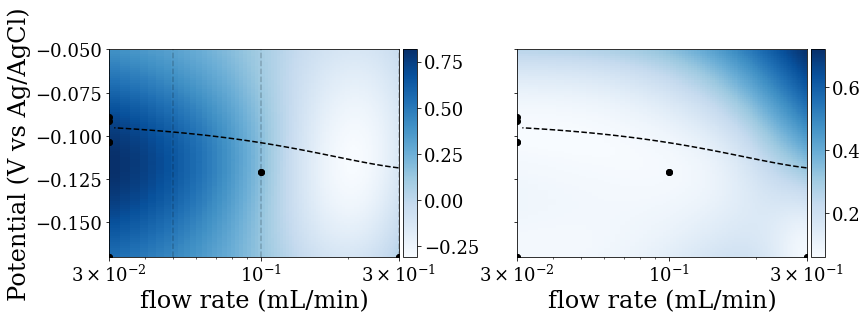

In [223]:
dx = 1 * np.ptp(candidates, axis=0)
ls = 2 * dx / 3
m_refl = emulation.model_property(
    X_ref,
    Y_ref,
    ls=ls,
    dx=dx,
    optimize=False,
    use_prior=True,
    kernel="RQ",
    noise_variance=0.05,
)
display_model(m_refl, candidates, X_ref, cvg=m_cov, X_next=X_next)


In [222]:
m_refl

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,(),float64,0.34165893773433087
GPR.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.047981936504602196
GPR.kernel.lengthscales,Parameter,Softplus,Gamma,True,"(2,)",float64,[0.00049138 0.01403373]
GPR.kernel.alpha,Parameter,Softplus,,True,(),float64,0.9338065350348804
GPR.likelihood.variance,Parameter,Softplus + Shift,Gamma,True,(),float64,0.02724984461983475


In [270]:
def display_full_model(m,  candidates, X_obs, cvg=None, X_next=None, X_dep=None, ax=None, label=None):

    loc, var = m.predict_y(candidates)

    loc = np.array(loc)
    var = np.array(var)

    I = ax.imshow(
        loc[:, 0].reshape(xx.shape), origin="lower", extent=extent, cmap="Blues"
    )
    cbar = visualization.colorbar(I)
    cbar.set_label(label)

    ax.scatter(X_obs[:, 0], X_obs[:, 1], color="k", s=80, edgecolor="w")

    if cvg is not None:
        cvg_loc, _ = cvg.predict_y(candidates)
        cvg_loc = np.array(cvg_loc)

        ax.contour(
            cvg_loc[:, 0].reshape(xx.shape),
            origin="lower",
            extent=extent,
            levels=[0.5],
            colors="k",
            linestyles="--",
        )

    if X_next is not None:
        ax.scatter(X_next[0], X_next[1], color="r")

    if X_dep is not None:
        ax.scatter(
            X_dep[:, 0], X_dep[:, 1], color="none", edgecolors="k", alpha=0.5
            )


    ax.semilogx()
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.03, 0.1, 0.3])
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_xlabel("flow rate (mL/min)")

    # ax.set_ylabel("Potential (V vs Ag/AgCl)")

    ax.annotate("poor\ncoverage", xy=(0.98, 0.56), xycoords="axes fraction", ha="right", fontsize=12)
    ax.annotate("full\ncoverage", xy=(0.98, 0.28), xycoords="axes fraction", ha="right", fontsize=12)

    plt.tight_layout()
    for lvl in query_levels:
        ax.axvline(lvl, linestyle="--", color="k", alpha=0.2)


Text(-4.700000000000003, 0.5, 'Potential (V vs Ag/AgCl)')

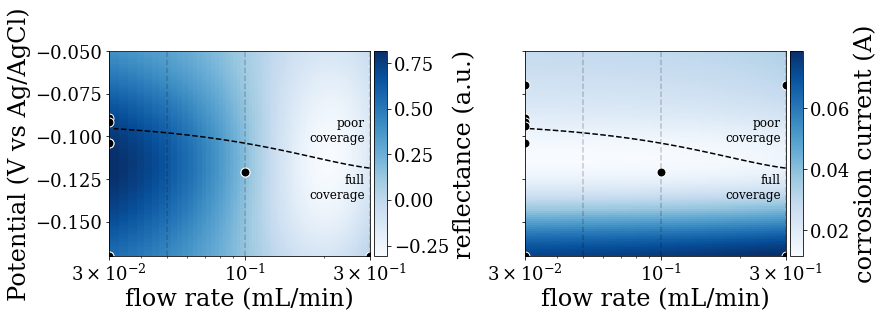

In [271]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
display_full_model(m_refl, candidates, X_ref, cvg=m_cov, X_next=X_next, ax=axes[0], label="reflectance (a.u.)")
display_full_model(m_corr, candidates, X_cor, cvg=m_cov, X_next=X_next, ax=axes[1], label="corrosion current (A)")
axes[0].set_ylabel("Potential (V vs Ag/AgCl)")


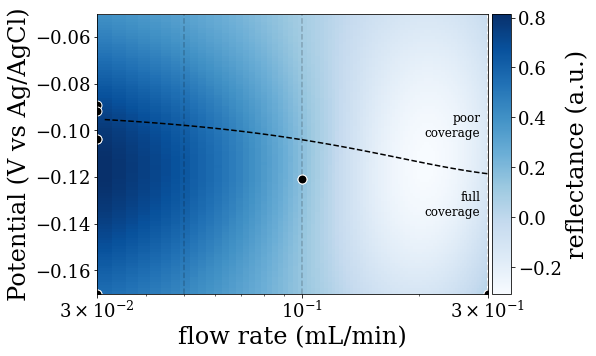

In [275]:
fig, ax = plt.subplots(figsize=(8, 5))
display_full_model(m_refl, candidates, X_ref, cvg=m_cov, X_next=X_next, ax=ax, label="reflectance (a.u.)")
ax.set_ylabel("Potential (V vs Ag/AgCl)")
plt.savefig("Cu_deposition_reflectance.pdf", bbox_inches="tight")

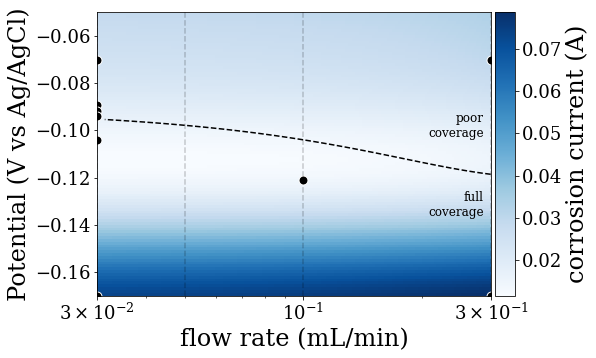

In [274]:
fig, ax = plt.subplots(figsize=(8, 5))
display_full_model(m_corr, candidates, X_cor, cvg=m_cov, X_next=X_next, ax=ax, label="corrosion current (A)")
ax.set_ylabel("Potential (V vs Ag/AgCl)")
plt.savefig("Cu_deposition_current.pdf", bbox_inches="tight")

## all the plots

In [29]:
for experiment_id in range(4, 11):
    print(experiment_id)

    X_dep, Y_dep, X_cor, Y_cor, X_ref, Y_ref, X_next = load_datasets(
        experiment_id=experiment_id
    )

    dx = 0.25 * np.ptp(candidates)
    m_cov = emulation.model_quality(
        X_dep, Y_dep[:, None], dx=dx, likelihood="bernoulli", optimize=True
    )
    display_model(m_cov, X_dep, cvg=m_cov, X_next=X_next)
    plt.savefig(f"figures/deposition-quality-{experiment_id:02d}.png")
    plt.clf()
    plt.close()

    m_corr = emulation.model_property(X_cor, Y_cor, dx=dx, optimize=True)
    display_model(m_corr, X_cor, cvg=m_cov, X_next=X_next, X_dep=X_dep)
    plt.savefig(f"figures/corrosion-current-{experiment_id:02d}.png")
    plt.clf()
    plt.close()

    m_refl = emulation.model_property(X_ref, Y_ref, dx=dx, optimize=True)
    display_model(m_refl, X_ref, cvg=m_cov, X_next=X_next, X_dep=X_dep)
    plt.savefig(f"figures/deposition-reflectivity-{experiment_id:02d}.png")
    plt.clf()
    plt.close()
    gpflow.reset_default_graph_and_session()


4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 8.051843
  Number of iterations: 19
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 8.051843
  Number of iterations: 19
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2.328976
  Number of iterations: 35
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2.328976
  Number of iterations: 35
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -7.248831
  Number of iterations: 29
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -7.248831
  Number of iterations: 29
  Number of functions evaluations: 34


5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 9.015031
  Number of iterations: 22
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 9.015031
  Number of iterations: 22
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.647607
  Number of iterations: 31
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.647607
  Number of iterations: 31
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -4.570685
  Number of iterations: 40
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -4.570685
  Number of iterations: 40
  Number of functions evaluations: 46


6
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 9.877653
  Number of iterations: 26
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 9.877653
  Number of iterations: 26
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -1.719673
  Number of iterations: 44
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -1.719673
  Number of iterations: 44
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -6.111304
  Number of iterations: 43
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -6.111304
  Number of iterations: 43
  Number of functions evaluations: 53


7
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 11.581749
  Number of iterations: 28
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 11.581749
  Number of iterations: 28
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -4.810994
  Number of iterations: 38
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -4.810994
  Number of iterations: 38
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 7.771362
  Number of iterations: 36
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 7.771362
  Number of iterations: 36
  Number of functions evaluations: 41


8
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 13.178343
  Number of iterations: 33
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 13.178343
  Number of iterations: 33
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -7.573927
  Number of iterations: 35
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -7.573927
  Number of iterations: 35
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 7.529347
  Number of iterations: 36
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 7.529347
  Number of iterations: 36
  Number of functions evaluations: 41


9
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 14.332346
  Number of iterations: 34
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 14.332346
  Number of iterations: 34
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -7.573927
  Number of iterations: 35
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -7.573927
  Number of iterations: 35
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 7.529347
  Number of iterations: 36
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 7.529347
  Number of iterations: 36
  Number of functions evaluations: 41


10
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 15.764176
  Number of iterations: 35
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 15.764176
  Number of iterations: 35
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -11.214750
  Number of iterations: 22
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -11.214750
  Number of iterations: 22
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 7.529347
  Number of iterations: 36
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 7.529347
  Number of iterations: 36
  Number of functions evaluations: 41


## plot current traces

In [37]:
import os
import cycvolt


def load_echem(
    row, data_dir="data", segment=0, half=False, log=True, show_applied=False
):
    """load CV data and process it..."""

    if show_applied:
        potential = "applied_potential"
    else:
        potential = "potential"
    cv = pd.read_csv(os.path.join(data_dir, row["datafile"]), index_col=0)

    sel = cv["segment"] == segment
    I = cv["current"][sel].values
    V = cv[potential][sel].values
    t = cv["elapsed_time"][sel].values

    # # grab the length of the polarization curve
    if half:
        n = I.size // 2
        I = I[:n]
        V = V[:n]

    if log:
        I = cycvolt.analyze.log_abs_current(I)

    return V, I, t - t[0]


In [63]:
df.iloc[17]


id                                                                18
intent                                                     corrosion
instructions       [{"op": "set_flow", "rates": {"H2SO4": 0.1}, "...
x_combi                                                         31.5
y_combi                                                          4.5
x_versa                                                    0.0343769
y_versa                                                    0.0197442
z_versa                                                    0.0252886
flag                                                           False
timestamp_start                           2019-11-22 14:52:24.608001
timestamp                                 2019-11-22 14:54:28.114001
error_codes                                                       []
measurement                           ["set_flow", "potentiostatic"]
parameters         "[{\"initial_potential\": 0.1, \"versus_initia...
flow_setpoint                     

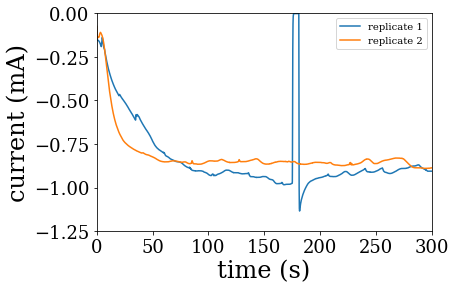

In [96]:
# idx = 15
idx = 18
V, I, t = load_echem(df.iloc[idx], half=False, log=False)
plt.plot(t, I * 1000, label="replicate 1")
plt.ylim(I.min() * 1100, 0)

V, I, t = load_echem(df.iloc[idx + 1], half=False, log=False)
plt.plot(t, I * 1000, label="replicate 2")
plt.xlabel("time (s)")
plt.ylabel("current (mA)")
plt.legend()

plt.xlim(0, 300)


(0, 0.5283323262119665)

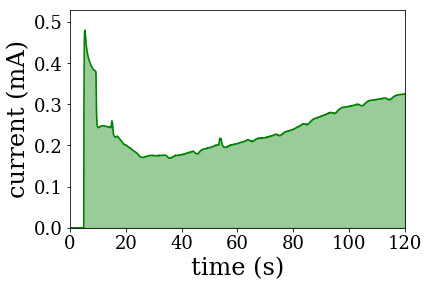

In [92]:
V, I, t = load_echem(df.iloc[idx + 2], half=False, log=False)
plt.plot(t, I * 1000, color="g")
plt.fill_between(t, 0, I * 1000, color="g", alpha=0.4)
plt.xlabel("time (s)")
plt.ylabel("current (mA)")
plt.xlim(0, 120)
plt.ylim(0, I.max() * 1100)


## check out the reproducibility of the syntheses...

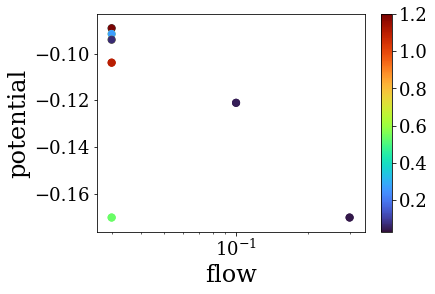

In [8]:
plt.semilogx()
rnd = 0.0 * np.random.random(df["potential"].size)
plt.scatter(
    df["flow_rate"] + rnd, df["potential"], c=df["reflectance"], s=50, cmap=turbo
)
plt.colorbar()
plt.xlabel("flow")
plt.ylabel("potential")


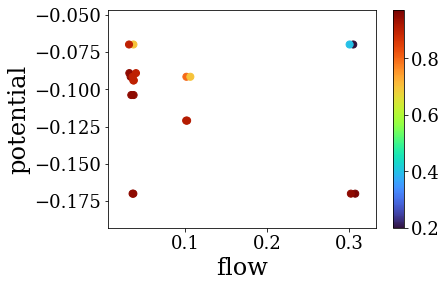

In [10]:
# plt.semilogx()
rnd = 0.01 * np.random.random(df["potential"].size)
plt.scatter(df["flow_rate"] + rnd, df["potential"], c=df["coverage"], s=50, cmap=turbo)
plt.colorbar()
plt.xlabel("flow")
plt.ylabel("potential")
